# Comparing DMSO and JQ1 treatments with DESeq2

Important notes:
  * here we are using the output of salmon
  * GRCh38 was used as reference genome, retrieved from the ensemble's site on 11/06/2022
  * The rna reference index contains non-coding rna-s as well (for more on the salmon and the parameters see the seq_processing notebook)
  * The applied experiment design was a simple case-vs-control (JQ1 vs DMSO). Note, however, that the original experiment design is more complex (with extra dimensions) (multiple time-points and resistent vs. non-resistent cell-lines). 
  * Important note: current data contains technical replicates, they should be 'collapsed' or one should directly encode this information into the underlying statistical model. For the sake of the demonstration I kept the original scenario. 
  * The gene annotation has a significant effect on the outputs which should be investigated carefully. Here I applied a pre-compiled annotation mapping.


## Inputs:
  * salmon outputs (quant.sf) files (pseudo counts, estimated TPM values)
 
## Outputs:
  * normalized count data
  * PCA plot for comparing the samples
  * dispersion plot (visualizing count structure)
  * Differential expressed genes table: statistical analysis (significantly DE genes, p-value correction)
  * Clustered heatmaps 
  * Gene set enrichment analyis (significantly affected KEGG pathways)
  * Other functional analysis (GO categories, basic pathways)
  


In [ ]:
## Display params:
options(repr.plot.width=10, repr.plot.height=10)


## Loading libraries
library(DESeq2)
library(tidyverse)
library(RColorBrewer)
library(pheatmap)
library(DEGreport)
library(tximport)
library(ggplot2)
library(ggrepel)
library( GenomicFeatures )

# Load libraries
library(DOSE)
library(pathview)
library(clusterProfiler)
library(org.Hs.eg.db)

## Inputs - Outputs

Here we define the input and output files as well as the sample descriptions. 


In [ ]:
base_dir <- '/bio-apps/turbine-rna/'
input_dir <- paste(base_dir,'results/salmon_GRCh38_outputs', sep = '')

sampletype <- factor(c(rep("dmso",2), rep("jq1", 2)))

## Outputs:

### Tables
normalized_counts_file <- paste(base_dir,'results/salmon_GRCh38_normalized_counts.tsv', sep = '' )
normalized_logt_counts_file <- paste(base_dir,'results/salmon_GRCh38_normalized_logt_counts.tsv', sep = '' )
differential_expressed_table_file <- paste(base_dir,'results/salmon_GRCh38_de_genes_all.tsv', sep = '' )
differential_expressed_sign_only_table_file <- paste(base_dir,'results/salmon_GRCh38_de_genes_sign.tsv', sep = '' )
gsea_file <- paste(base_dir,'results/salmon_GRCh38_gsea_kegg.tsv', sep = '' )

### Plots:
pca_plot_file <- paste(base_dir,'results/salmon_GRCh38_samples_pca_plot.png', sep = '' )
ma_plot_file <- paste(base_dir,'results/salmon_GRCh38_samples_ma_plot.png', sep = '' )
heatmap_gene_sample_file <- paste(base_dir,'results/salmon_GRCh38_samples_heatmap_gene_sample.png', sep = '' )
heatmap_sample_sample_file <- paste(base_dir,'results/salmon_GRCh38_samples_heatmap_sample_sample.png', sep = '' )
vulcano_plot_file <- paste(base_dir,'results/salmon_GRCh38_samples_vulcano_plot.png', sep = '' )
go_enrichment_plot_file <- paste(base_dir,'results/salmon_GRCh38_encrichment_go.png', sep = '' )
go_network_enrichment_plot_file <- paste(base_dir,'results/salmon_GRCh38_encrichment_go_network.png', sep = '' )
go_network_enrichment_plot_file <- paste(base_dir,'results/salmon_GRCh38_encrichment_go_network.png', sep = '' )

go_gene_assoc_plot_file <- paste(base_dir,'results/salmon_GRCh38_encrichment_go_gene.png', sep = '' )


## Loading the salmon data into DESeq2


In [ ]:
# Get SALMON outputs
tx2gene <- read.delim(paste(base_dir,'data/tx2gene_grch38.txt', sep = ""))
samples <- list.files(path = input_dir, full.names = T, pattern="trimmed$")
files <- file.path(samples, "quant.sf")

names(files) <- str_replace(samples, input_dir, "") %>%
                str_replace('/', "") %>% 
                str_replace(".salmon", "")

txi <- tximport(files, type="salmon", tx2gene=tx2gene[,c("tx_id", "ensgene")], countsFromAbundance="lengthScaledTPM",ignoreTxVersion = TRUE, ignoreAfterBar = TRUE)

# Create the expression data object with sample annotation
data <- txi$counts %>% 
  round() %>% 
  data.frame()
meta <- data.frame(sampletype, row.names = colnames(txi$counts))


### Creating DESeq2 object from the loaded data


In [ ]:
### Check that sample names match in both files

# Fast check for the inputs
all(colnames(txi$counts) %in% rownames(meta))
all(colnames(txi$counts) == rownames(meta))
dds <- DESeqDataSetFromTximport(txi, colData = meta, design = ~ sampletype)
dds <- estimateSizeFactors(dds)

grch38annot <- tx2gene %>% 
               dplyr::select(ensgene, symbol) %>% 
               dplyr::distinct()
normalized_counts <- counts(dds, normalized=T) %>% 
                     data.frame() %>%
                     rownames_to_column(var="gene") 
normalized_counts <- merge(normalized_counts, grch38annot, by.x="gene", by.y="ensgene")
normalized_counts <- normalized_counts %>%
                     as_tibble()
write.table(normalized_counts, file=normalized_counts_file, sep="\t", quote=F, col.names=NA)
log_data <- rlog(dds, blind=TRUE)
write.table(assay(log_data), file=normalized_logt_counts_file, sep="\t", quote=F, col.names=NA)

## PCA plot for the samples


In [ ]:
plotPCA(log_data, intgroup="sampletype")
dev.copy(png,pca_plot_file)
dev.off()
rld_mat <- assay(log_data)
pca <- prcomp(t(rld_mat))
df <- cbind(meta, pca$x)

### Notes
One could expect that the technical replicates of the same experiment should be closer to each other compared to samples of different experiments. Unfortunately, here we only have 2 vs 2 samples, which might be misleading. The PCA analysis tries to capture the variance (find a projection from N dim to 2 dim that captures as much variance as possible.) One should look into the factors as well, to see which genes drive the PC1 and PC2 the most (biplot PCA). UMAP is a good alternative visualization and analysis technique. (In this mini problem it would be an overkill and misleading.)



## Statistical analysis

DESeq2 fits statistical models to the count data, then assesses the significance using Wald tests. 

In [ ]:
# Evalutating actual stat analysis (for more details see the DESeq2 material or paper)
dds <- DESeq(dds)
dds_lrt <- DESeq(dds, test="LRT", reduced = ~ 1)
contrast_oe <- c("sampletype", "dmso", "jq1")
res_tableOE_unshrunken <- results(dds, contrast=contrast_oe, alpha = 0.05)
res_tableOE <- lfcShrink(dds, coef="sampletype_jq1_vs_dmso", type="apeglm")

In [ ]:
# MA plot from the FOLD changes
dev.copy(png,ma_plot_file)
plotMA(res_tableOE, ylim=c(-2,2))

dev.off()


In [ ]:
summary(res_tableOE, alpha = 0.05)
### Set thresholds
padj.cutoff <- 0.05
# Create a tibble of results
res_tableOE_tb <- res_tableOE %>%
  data.frame() %>%
  rownames_to_column(var="gene") %>% 
  as_tibble()
# Subset the tibble to keep only significant genes
sigOE <- res_tableOE_tb %>%
        filter(padj < padj.cutoff)
norm_OEsig <- normalized_counts %>% 
              filter(gene %in% sigOE$gene)

write.table(res_tableOE_tb, file=differential_expressed_table_file, sep="\t", quote=F, col.names=NA)
write.table(norm_OEsig, file=differential_expressed_sign_only_table_file, sep="\t", quote=F, col.names=NA)


### Heatmaps


png 
  3

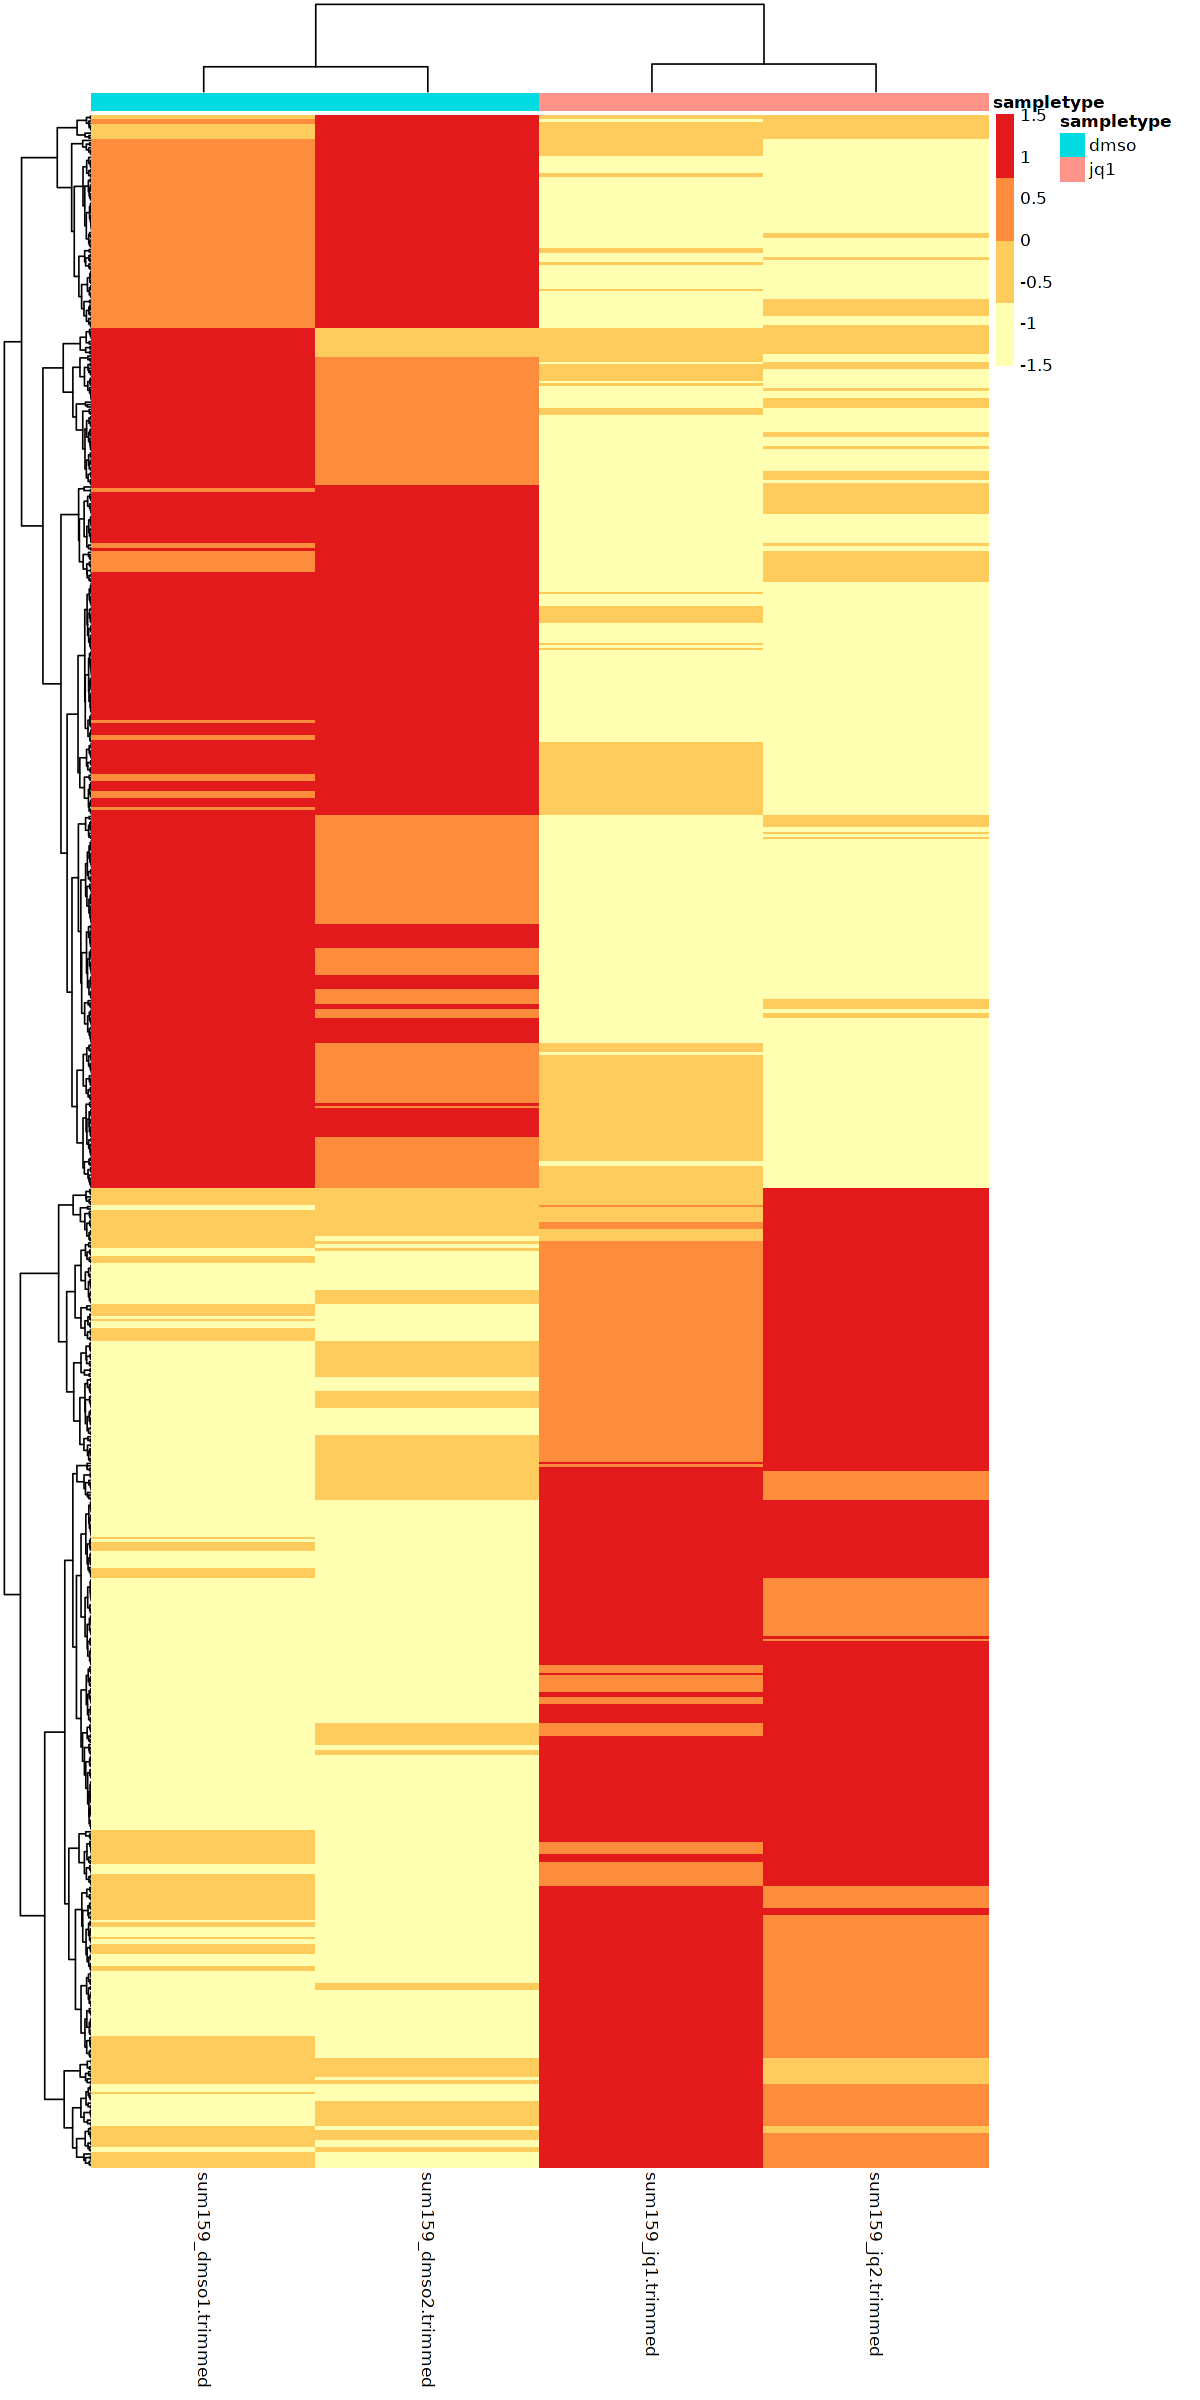

In [15]:
### Set a color palette

heat_colors <- brewer.pal(4, "YlOrRd")
### Run heatmap using the metadata for the annotation
options(repr.plot.width=10, repr.plot.height=20)


res_tableOE_tb <- res_tableOE_tb %>% 
                  mutate(threshold_OE = padj < 0.05 & abs(log2FoldChange) >= 1)

pheatmap(norm_OEsig[2:5], 
    color = heat_colors, 
    cluster_rows = T, 
    show_rownames = F,
    annotation = meta, 
    border_color = NA, 
    fontsize = 10, 
    scale = "row", 
    fontsize_row = 10, 
    height = 20)

# Saving the figure into file
png(heatmap_gene_sample_file, width = 1000, height = 1500)
pheatmap(norm_OEsig[2:5], 
    color = heat_colors, 
    cluster_rows = T, 
    show_rownames = F,
    annotation = meta, 
    border_color = NA, 
    fontsize = 10, 
    scale = "row", 
    fontsize_row = 10, 
    height = 20)

dev.off()


In [ ]:
# Calculating the correlations using the corrected log transformed values
options(repr.plot.width=10, repr.plot.height=10)


rld_cor <- cor(rld_mat)
pheatmap(rld_cor, annotation = meta)

dev.copy(png,heatmap_sample_sample_file)
dev.off()


### Heatmaps analysis
Overally, the technical replicates are strongly correlated as well as the DMSO and jg1 samples, indicating that the correlation metric is not really useful here as it takes all transcripts into account. 




### Vulcano plot

In [16]:
## Vulcano plot
options(repr.plot.width=10, repr.plot.height=10)
dev.copy(png,vulcano_plot_file)


ggplot(res_tableOE_tb) +
    geom_point(aes(x = log2FoldChange, y = -log10(padj), colour = threshold_OE)) +
    ggtitle("Mov10 overexpression") +
    xlab("log2 fold change") + 
    ylab("-log10 adjusted p-value") +
    #scale_y_continuous(limits = c(0,50)) +
    theme(legend.position = "none",
          plot.title = element_text(size = rel(1.5), hjust = 0.5),
          axis.title = element_text(size = rel(1.25))) 

dev.off()


png 
  8

Warning message:
“Removed 45779 rows containing missing values (geom_point).”


png 
  2

## Enrichment analysis

Here we are going to evaluate the top differentially expressed genes by mapping them to gene ontology categories and KEGG pathways. For the gene ontology analysis I am going to use 'traditional' hypergeometric test for assessing the enrichment to GO categories. 
Another alternative approach is the gene set enrichment analaysis, which takes into account all genes, not only the siginifant ones. Here I just use the KEGG pathways as examples, but there are many more classes of predefined gene sets (like cancer driver genes, hallmark genes, etc) 



In [ ]:
annotations_ahb <- read.csv("/home/ligeti/gitrepos/turbine-rnaseq-ligeti/data/annotations_small.csv")

res_ids <- left_join(res_tableOE_tb, annotations_ahb, by=c("gene"="gene_id"))    
allOE_genes <- as.character(res_ids$gene)

## Extract significant results
sigOE <- dplyr::filter(res_ids, padj < 0.05)
sigOE_genes <- as.character(sigOE$gene)

res_ids <- left_join(res_tableOE_tb, annotations_ahb, by=c("gene"="gene_id"))    
## Create background dataset for hypergeometric testing using all genes tested for significance in the results                 
allOE_genes <- as.character(res_ids$gene)

## Extract significant results
sigOE <- dplyr::filter(res_ids, padj < 0.05)
sigOE_genes <- as.character(sigOE$gene)


In [ ]:
## Run GO enrichment analysis 
ego <- enrichGO(gene = sigOE_genes, 
                universe = allOE_genes,
                keyType = "ENSEMBL",
                OrgDb = org.Hs.eg.db, 
                ont = "BP", 
                pAdjustMethod = "BH", 
                qvalueCutoff = 0.05, 
                readable = TRUE)


In [ ]:
## Output results from GO analysis to a table

options(repr.plot.width=10, repr.plot.height=20)
cluster_summary <- data.frame(ego)
dotplot(ego, showCategory=40)

png(go_enrichment_plot_file, width = 1000, height = 2000)
dotplot(ego, showCategory=40)
dev.off()


In [ ]:
options(repr.plot.width=15, repr.plot.height=20)

library(ggnewscale)
## Add similarity matrix to the termsim slot of enrichment result
ego <- enrichplot::pairwise_termsim(ego)

## Enrichmap clusters the 30 most significant (by padj) GO terms to visualize relationships between terms
emapplot(ego, showCategory = 30)

# Saving figure
png(go_network_enrichment_plot_file, width = 1500, height = 2000)
emapplot(ego, showCategory = 30)
dev.off()


#### Plot gene and top GO categories association
Plotting the associations between the GO categories and the individual genes. 
The size will represent the p-value (the more significant the larger the gene); 
the colormap represents the foldchange (direction included)


In [ ]:
## To color genes by log2 fold changes, we need to extract the log2 fold changes from our results table creating a named vector
OE_foldchanges <- sigOE$log2FoldChange
names(OE_foldchanges) <- sigOE$gene


OE_foldchanges <- ifelse(OE_foldchanges > 4, 4, OE_foldchanges)
OE_foldchanges <- ifelse(OE_foldchanges < -4, -4, OE_foldchanges)
cnetplot(ego, 
         categorySize="pvalue", 
         showCategory = 5, 
         foldChange=OE_foldchanges, 
         vertex.label.font=6)

# Saving the figure
png(go_gene_assoc_plot_file, width = 1500, height = 2000)
cnetplot(ego, 
         categorySize="pvalue", 
         showCategory = 5, 
         foldChange=OE_foldchanges, 
         vertex.label.font=6)
dev.off()